In [26]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
%matplotlib inline

In [27]:
# Format floats
pd.options.display.float_format = '{:,.2f}'.format

In [28]:
# Resize charts via seaborn
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 22})

In [29]:
hs_deals = 'hs_deals-2018_10_15.csv'
df_deals_raw = pd.read_csv(hs_deals)

In [30]:
hs_companies = 'hs_companies-2018_10_15.csv'
df_companies_raw = pd.read_csv(hs_companies)

In [31]:
hs_contacts = 'hs_contacts-2018_10_15.csv'
df_contacts_raw = pd.read_csv(hs_contacts, low_memory=False)

## Exploration & Cleaning

### Dataset: Companies_Raw

In [32]:
# Won't work!
# df_companies['Annual Revenue'] = df_companies['Annual Revenue'].map('${:,.0f}'.format)

In [33]:
#Limit df to rows with entries for Website URL
df_companies = df_companies_raw.dropna(axis='index', subset=['Company Domain Name'])

In [34]:
#Limit df to columns with at least 150 entries
df_companies = df_companies.dropna(axis='columns',thresh=150)


In [35]:
# Drop columns that aren't relevant to the problem
# Number of Pageviews and Visits were almost all 0
df_companies.drop(['LinkedIn Bio', 'Company ID', 'Last Modified Date', 'Postal Code', 'Time of Last Session', 
                   'Time of First Visit', 'Booth Number OR Summer 2018', 'Recent Deal Amount',
                   'TS Next Steps', 'Salesforce Account ID', 'First Deal Created Date',
                   'Booth Number Cosmoprof Summer 2018', 'Phone Number', 'State/Region', 
                   'TS status', 'Street Address', 'Account Number', 'Last Salesforce Sync Time', 
                   'Street Address 2', 'Number of Pageviews', 'Number of Visits', 'City', 'Description'], axis=1, inplace=True)

In [87]:
#Rename columns
df_companies.rename(columns={'Total Revenue':'Total_Rev',
                             'Annual Revenue':'Annual_Rev',
                             'Company Domain Name':'Domain_Name',
                             'Last Touch Converting Campaign':'Last_T_Campaign', 
                             'Recent Deal Close Date':'Recent_Deal_Date',
                             'Number of Employees':'Employees',
                             'Close Date':'Close_date',
                             'First Conversion Date':'1st_Conversion_date',
                             'Number of times contacted':'Times_Contacted',
                             'Original Source Type':'Original_Source_Name',
                             'Number of Form Submissions':'Forms_Subm',
                             'Facebook Company Page':'FB_Co_page',
                             'Create Date':'Create_Date',
                             'First Conversion':'1st_Conversion',
                             'Company Owner':'Company_Owner',
                             'LinkedIn Company Page':'LinkedIn_Page',
                             'Total Money Raised':'Money_Raised',
                             'Owner Assigned Date':'Owner_Assigned_Date',
                             'Associated Deals':'Assoc_Deals',
                             'Associated Contacts':'Assoc_Contacts',
                             'Original Source Data 1':'Orig_Source_1',
                             'Recent Conversion Date':'Conversion_Date',
                             'Original Source Data 2':'Orig_Source_2',
                             'Lifecycle Stage':'Lifecycle_Stage',
                             'Last Contacted':'Last_Contacted',
                             'Recent Conversion':'Recent_Conversion',
                             'HubSpot Team':'HubSpot_Team',
                             'Web Technologies':'Web_Technologies',
                             'Likelihood to close':'Likelihood_to_Close',
                             'First Contact Create Date':'1st_Contact_Date',
                             'Time Zone':'Time_Zone',
                             'Time Last Seen':'Time_Last_Seen',
                             'Time First Seen':'Time_1st_Seen',
                             'Website URL':'Website_URL',
                             'Year Founded':'Year_Founded',
                             'Twitter Handle':'Twitter_Handle',
                             'Days to Close':'Days_to_Close',
                             'Account Manager':'Account_Manager',
                             'Is Public':'Is_Public',
}, inplace=True)

In [88]:
df_companies[
    ['Employees','Times_Contacted', 
     'Forms_Subm', 'Assoc_Contacts', 
     'Annual_Rev']] = df_companies[
    ['Employees','Times_Contacted', 
     'Forms_Subm', 'Assoc_Contacts', 
     'Annual_Rev']].apply(pd.to_numeric)

In [89]:
# Fill n/a
df_companies.Num_of_Form_Subm = df_companies.Forms_Subm.fillna(0)
df_companies.Times_Contacted = df_companies.Times_Contacted.fillna(0)
df_companies.Assoc_Contacts = df_companies.Assoc_Contacts.fillna(0)
#Filled over 2,000 observations for the year founded attribute, perhaps too many?
#df_companies['Year Founded'] = df_companies['Year Founded'].fillna(df_companies['Year Founded'].mode())
# ???
#df_companies.Total_Rev = df_companies.Total_Rev
# By revenue size
# df_companies.Num_of_Employees = df_companies.Num_of_Employees

In [90]:
df_companies[['Employees', 'Annual_Rev', 'Times_Contacted', 
     'Forms_Subm', 'Assoc_Contacts', 'Year_Founded']].describe()

,Employees,Annual_Rev,Times_Contacted,Forms_Subm,Assoc_Contacts,Year_Founded
count,"5,136.00","5,178.00","6,814.00",626.00,"6,814.00","4,542.00"
mean,"1,209.78","149,710,121.98",4.50,1.42,1.62,"1,983.54"
std,"3,884.58","314,590,962.24",7.92,2.59,1.77,34.98
min,2.00,"5,600.00",0.00,1.00,0.00,"1,689.00"
25%,25.00,"10,000,000.00",0.00,1.00,1.00,"1,976.00"
50%,50.00,"10,000,000.00",2.00,1.00,1.00,"1,996.00"
75%,200.00,"50,000,000.00",6.00,1.00,2.00,"2,007.00"
max,"100,000.00","1,000,000,000.00",100.00,53.00,40.00,"2,017.00"


## Features

In [91]:
features = pd.DataFrame()

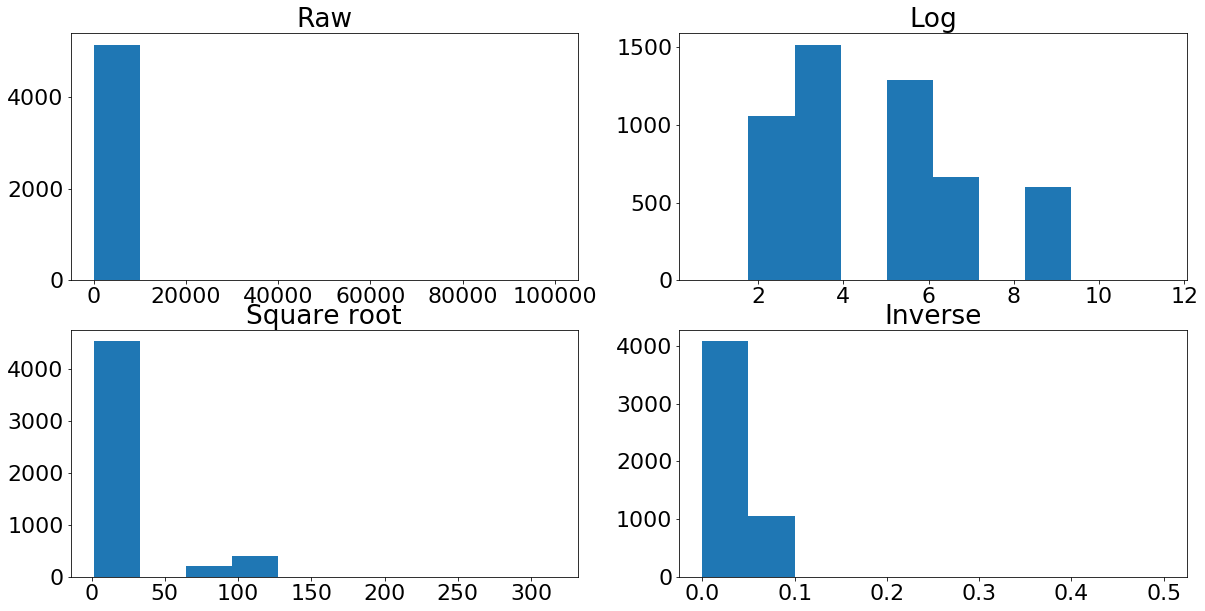

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [92]:
# Making a four-panel plot.
fig = plt.figure()

fig.add_subplot(221)
plt.hist(df_companies.Employees.dropna())
plt.title('Raw')

fig.add_subplot(222)
plt.hist(np.log(df_companies.Employees.dropna()))
plt.title('Log')

fig.add_subplot(223)
plt.hist(np.sqrt(df_companies.Employees.dropna()))
plt.title('Square root')

ax3=fig.add_subplot(224)
plt.hist(1/df_companies.Employees.dropna())
plt.title('Inverse')
plt.show()

# Log feature is most normalized

features.Employees_log = np.log(df_companies.Employees.dropna())

### Principal Component Analysis

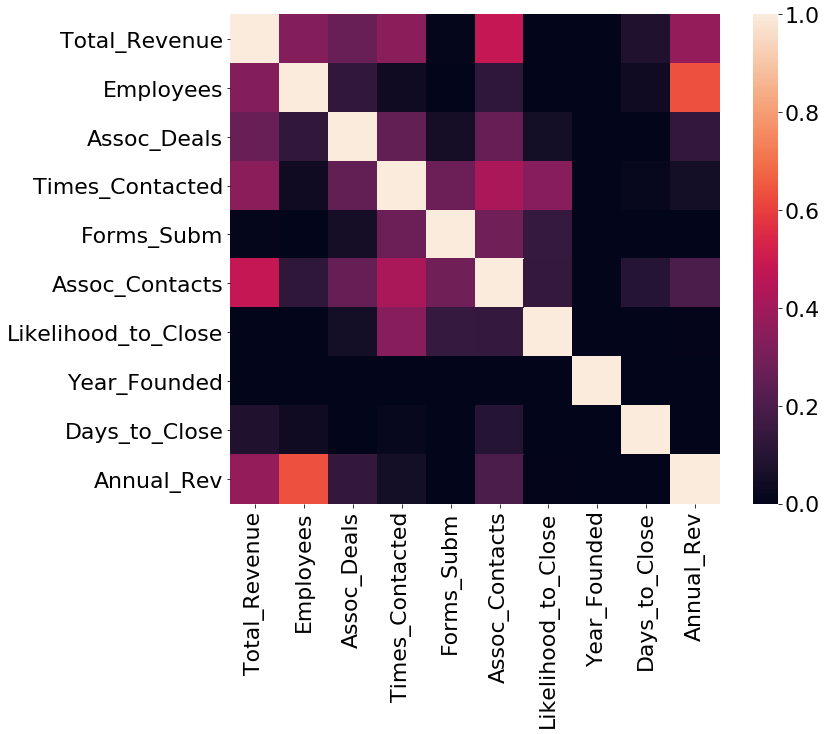

              Annual_Rev  Employees  Company_Size
Annual_Rev          1.00       0.63          0.91
Employees           0.63       1.00          0.91
Company_Size        0.91       0.91          1.00


In [93]:
corrmat = df_companies.corr()

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmin=0, vmax=1, square=True)
plt.show()

# Looks like 'pplfair','ppltrst' and 'pplhlp' are pretty redundant with each
# other. Let's make some averages. Just in case some of the variables are on
# different scales than others (one ranges from 0 to 100, one ranges from 0 to
# 7, for example) we scale them before averaging by subtracting the average of
# each variable from all values in that variable, then dividing by the
# standard deviation.
means = df_companies[['Annual_Rev','Employees']].mean(axis=0)
stds = df_companies[['Annual_Rev','Employees']].std(axis=0)
features['Company_Size'] = ((df_companies[['Annual_Rev','Employees']] - means) / stds).mean(axis=1)

# Check how well the composite correlates with each of the individual variables.
plotdf = df_companies.loc[:, ['Annual_Rev', 'Employees']]
plotdf['Company_Size'] = features['Company_Size'] 
corrmat2 = plotdf.corr()

print(corrmat2)

In [94]:
# def WinsorizeCustom(data):
#     quantiles = data.quantile([0.05, 0.95])
#     q_05 = quantiles.loc[0.05]
#     q_95 = quantiles.loc[0.95]

#     out = np.where(data.values <= q_05,q_05, 
#                                       np.where(data >= q_95, q_95, data)
#                   )
#     return out

In [95]:
# Take a subset of the data for PCA by removing outliers and NaNs.
# df_pca = df_companies[['Annual_Rev', 'Employees']].copy()
# df_pca.Annual_Rev = df_pca.Annual_Rev.dropna()
# df_pca.Employees = df_pca.Employees.dropna()
# df_pca.Annual_Rev = WinsorizeCustom(df_pca.Annual_Rev)
# df_pca.Employees = WinsorizeCustom(df_pca.Employees)

In [96]:
# sns.barplot(x=df_pca.Annual_Rev.value_counts().index, y=df_pca.Annual_Rev.value_counts())

### Other Features

In [97]:
#Create empty dataframe
df_features = pd.DataFrame()

In [101]:
# Binary features
df_features['has_deal'] = np.where(df_companies.Assoc_Deals.isnull(), 0, 1)
df_features['was_customer'] = np.where(df_companies.Total_Revenue.isnull(), 0, 1)
df_features['has_bdr'] = np.where(df_companies.BDR.isnull(), 0, 1)
df_features['submitted_form'] = np.where(df_companies.Forms_Subm>0, 1, 0)

Text(0,0.5,'Frequency')

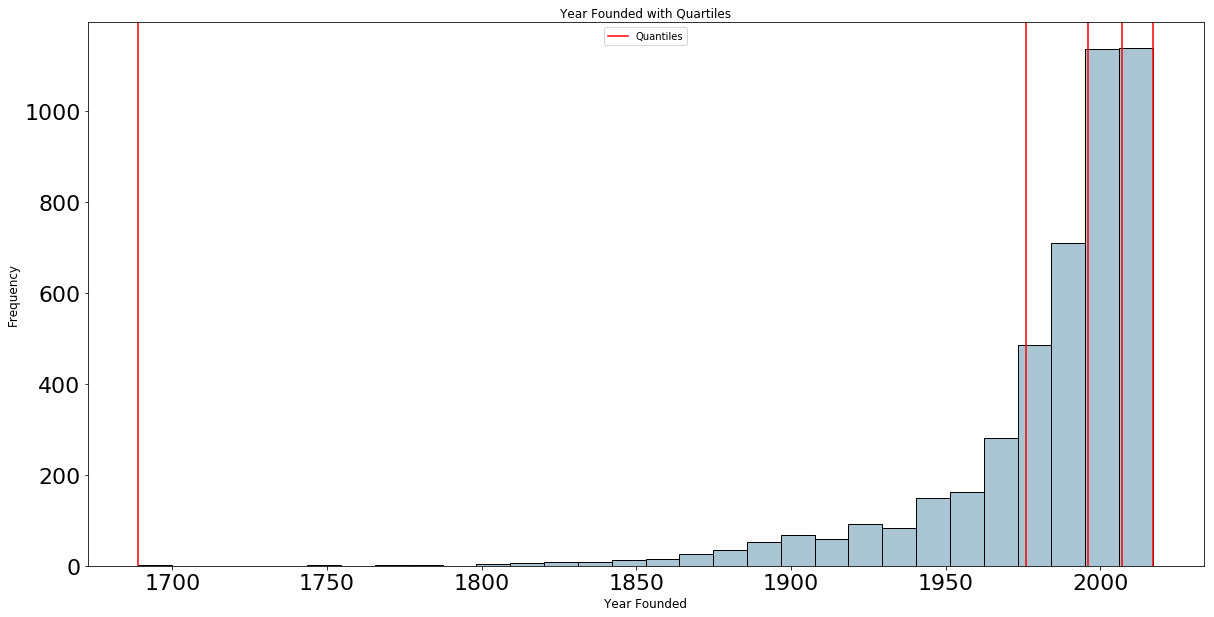

In [103]:
# Adaptive bins for Year
quantile_list = [0, .25, .5, .75, 1.]
quantiles = df_companies.Year_Founded.quantile(quantile_list)
fig, ax = plt.subplots()
df_companies.Year_Founded.hist(bins=30, color='#A9C5D3', 
                             edgecolor='black', grid=False)
for quantile in quantiles:
    qvl = plt.axvline(quantile, color='r')
ax.legend([qvl], ['Quantiles'], fontsize=10)
ax.set_title('Year Founded with Quartiles', 
             fontsize=12)
ax.set_xlabel('Year Founded', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [106]:
quantile_labels = ['0-25Q', '25-50Q', '50-75Q', '75-100Q']
df_companies['year_founded_quartile_range'] = pd.qcut(df_companies.Year_Founded,
                                       q=quantile_list)
df_companies['year_founded_quartile_label'] = pd.qcut(df_companies.Year_Founded,
                                                 q=quantile_list,
                                                 labels=quantile_labels)

df_companies[['Year_Founded', 'year_founded_quartile_range', 'year_founded_quartile_label']].iloc[4:9]

,Year_Founded,year_founded_quartile_range,year_founded_quartile_label
4,nan,NaN,NaN
5,nan,NaN,NaN
6,nan,NaN,NaN
7,"1,998.00","(1996.0, 2007.0]",50-75Q
8,nan,NaN,NaN


In [ ]:
# Python Crashes
# sns.pairplot(df_companies)

In [109]:
features = pd.get_dummies(df_companies['Assoc_Deals'])

## df_companies.info()

### Scott Data Clean-up

In [14]:
#df_companies_raw['Company Domain Name'].isna()

In [15]:
#df_companies_raw['TrackStreet or Sticky?'].dropna()